In [1]:
import sys
!{sys.executable} -m pip install scikit-learn pandas graphviz


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, out_file="tree_vis.dot", feature_names=["petal length (cm)", "petal width (cm)"], class_names=iris.target_names, rounded=True, filled=True)



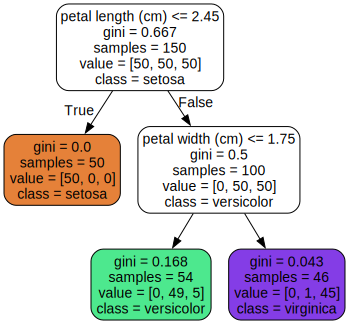

In [4]:
from graphviz import Source

Source.from_file("tree_vis.dot")

In [5]:
tree_clf.predict_proba([[5, 1.5]]).round(3)
tree_clf.predict([[5, 1.5]])

array([1])

In [6]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [7]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, random_state=43, noise=0.2)

print(f"Tree 1 Score: {tree_clf.score(X_moons_test, y_moons_test)}") # Because there was no regularization on this tree it overfit the training data

print(f"Tree 2 Score: {tree_clf2.score(X_moons_test, y_moons_test)}")

Tree 1 Score: 0.898
Tree 2 Score: 0.92


In [8]:
# DT Regression
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad ** 2 + 0.025 + np.random.rand(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [9]:
# Apply PCA to reduce axis orientation sensitivity
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [10]:
# What is the appropriate length of a decision tree on a training set with 1 million instances
# NOTE: IF there is no max depth then the tree would have a depth of n/2?

# Is a nodes Gini impurity generally lower or higher than it's parents? Is it always lower/higher or generally
# NOTE: It's generally lower if the model fits well because the tree should have decreased impurity at the lower levels

# If a decision tree is overfitting the training set is it a good idea to try decreasing the max depth?
# NOTE: YES. If a decision tree has a high enough max depth it may keep splitting to a point of overfitting

# IF a decision tree is underfitting the trainging set is it a good idea to try to scale the input features
# NOTE: Scaling input features would resolve problems with OVERFITTING and NOT underfitting

# If it takes 1 hour to train a decision tree on the training set containing 1 million instances. How long would it take to train a decision tree using 10 million instances. CONSIDER THE CART COMPLEXITY. 
# NOTE: At a log scaling it would take 70 minutes?

# If it takes one hour to train a decision tree on a given training set. How much time would it take if you double the features.
# NOTE: log(2n)?

In [ ]:
# Train and fine tune a decision tree for the moon dataset

# Use make_moons(n_samples=10000, noise=0.4)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split


X_moons, y_moons = make_moons(n_samples=100000, noise=0.4)
# Use train test split
X_train,  X_test, y_train, y_test = train_test_split(X_moons, y_moons, random_state=42, test_size=0.2)

# Use grid search with cross validation
params = {"max_depth": [1, 5, 10, 25, 50, 100]}
tree_clf = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(tree_clf, params, n_jobs=16, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print(clf.best_params_.get("max_depth"))

# Train it on the full training set and mesaure the performance
best_tree_clf = DecisionTreeClassifier(max_depth=clf.best_params_.get("max_depth"), random_state=42)
best_tree_clf.fit(X_train, y_train)

y_pred = best_tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)


10
0.861215


In [ ]:
# Grow a forest
scores = []
n_trees = 1000
n_instances = 100
# Generate 1000 subsets of the training set. Each containing 100 instances. Use Shuffle split
from sklearn.model_selection import ShuffleSplit

mini_sets = []

split = ShuffleSplit(n_splits=n_trees, random_state=42, test_size=(len(X_train) - n_instances))

for train_index, test_index in split.split(X_train):
    X_train_mini = X_train[train_index]
    y_train_mini = y_train[train_index]
    mini_sets.append((X_train_mini, y_train_mini))

In [26]:
from sklearn.base import clone
from scipy.stats import mode

forest = [clone(clf.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

y_majority, n_votes = mode(Y_pred, axis=0)
accuracy_score(y_test, y_majority.reshape([-1]))

0.862185